$$S_i = S_{0i} e^{-(\alpha_i + j\omega_i)t}e^{j\phi_i}$$

$$S_i = S_{0i} e^{-(\alpha_i + j\omega_i)kT_s}e^{j\phi_i}$$

$$S_i = S_{0i} e^{(-(\alpha_i + j\omega_i)T_s)k}e^{j\phi_i}$$

$$e^{jx} = cos(x) + jsin(x)$$

$$e^{y + jx} = e^ye^{jx} = e^y(cos(x) + jsin(x))$$

$$e^{-\alpha T_s - j\omega T_s} = e^{-\alpha T_s}(cos(\omega T_s) + jsin(\omega T_s))$$

Considerando:

$$e^{-\alpha T_s} = |a + jb|$$

$$-\alpha T_s = \log(\sqrt{a^2 + b^2})$$

$$\alpha = -\frac{\log(\sqrt{a^2 + b^2})}{T_s}$$



Considerando o cálculo de um polo com valor $z = a + jb$:

$$e^{-\alpha T_s}(cos(\omega T_s) + jsin(\omega T_s)) = a + jb$$

$$e^{-\alpha T_s}cos(\omega T_s) = a$$

$$e^{-\alpha T_s}sin(\omega T_s) = b$$

$$-\alpha T_s + \log(cos(\omega T_s)) = \log(a)$$

$$\alpha T_s = \log(cos(\omega T_s)) - \log(a)$$

$$e^{-\alpha T_s}sin(\omega T_s) = b$$

$$\alpha T_s = \log(sin(\omega T_s)) - log(b)$$

No final, obtemos:

$$\alpha T_s = \log(cos(\omega T_s)) - \log(a)$$

$$\alpha T_s = \log(sin(\omega T_s)) - \log(b)$$

Subtraindo a primeira da segunda:

$$0 = \log(sin(\omega T_s)) - \log(b) - \log(cos(\omega T_s)) + \log(a)$$

$$0 = \log(\frac{sin(\omega T_s)}{cos(\omega T_s)}) - \log(b) + \log(a)$$

$$0 = \log(tan(\omega T_s)) + \log(\frac{a}{b})$$

$$1 = \frac{a \ tan(\omega T_s)}{b}$$

$$\omega = \frac{1}{T_s} \arctan(\frac{b}{a})$$

Que nos permite também solucionar para $\alpha$:

$$\alpha = \frac{1}{T_s} \log(\frac{cos(\arctan(\frac{b}{a}))}{a})$$



Considerando agora o cálculo de um resíduo $R = c + jd$:

$$S_0 (cos(\phi) + jsin(\phi)) = c + jd$$

$$S_0 cos(\phi) = c$$

$$S_0 sin(\phi) = d$$

Fazendo a razão da segunda pela primeira:

$$\frac{S_0}{S_0}\frac{sin(\phi)}{cos(\phi)} = \frac{d}{c}$$

$$\phi = \arctan(\frac{d}{c})$$

Substituindo na primeira equação:

$$S_0 = \sqrt{(c^2 + d^2)}$$

Sendo assim, considerando o cálculo de polos e resíduos da forma:

$$z = a + jb$$

$$R = c + jd$$

Temos:

| $S_0$ | $\phi$ | $\omega$ | $\alpha$ | 
| ----- | ------ | -------- | -------- |
| $\sqrt{(c^2 + d^2)}$ | $\arctan(\frac{d}{c})$ | $\frac{1}{T_s} \arctan(\frac{b}{a})$ | $ -\frac{\log(\sqrt{a^2 + b^2})}{T_s} $ | 

É importante comentar que para os cálculos $\phi$ e $\omega$, o ajuste de quadrantes deve ser feito, pois a função $\arctan$ só retorna valores entre $-\frac{\pi}{2}$ e $\frac{\pi}{2}$. O ajuste é feito da seguinte maneira:

   - **Quadrante I** $((a > 0, b > 0)): \theta = \arctan\left(\frac{b}{a}\right)$
   - **Quadrante II** $((a < 0, b > 0)): \theta = \pi + \arctan\left(\frac{b}{a}\right)$
   - **Quadrante III** $((a < 0, b < 0)): \theta = -\pi + \arctan\left(\frac{b}{a}\right)$
   - **Quadrante IV** $((a > 0, b < 0)): \theta = \arctan\left(\frac{b}{a}\right)$ (Mesmo que o quadrante I, mas negativo)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from numpy.fft import fft, fftfreq, fftshift
from pyMRI.utils import RMSEll

In [81]:
def calculate_variables_from_z_and_r(z : np.complex128, r : np.complex128, ts : float):
    a, b, c, d = z.real, z.imag, r.real, r.imag
    s0 = np.sqrt(c**2 + d**2)
    phi = ( + np.pi*(np.logical_and(c < 0, d > 0)) 
            - np.pi*(np.logical_and(c < 0, d < 0)) 
            + np.arctan(d/c))
    omega = (1/ts)*(+ np.pi*(np.logical_and(a < 0, b > 0)) 
                    - np.pi*(np.logical_and(a < 0, b < 0)) 
                    + np.arctan(b/a))
    alpha = -(1/ts)*np.log( np.sqrt((a**2 + b**2)) )
    return s0, phi, omega, alpha


In [65]:
metabolites = pymri.METABOLITES

t0 = 0.0
tn = 1.0
n_points = 2048
Dt = tn - t0
dt = Dt/n_points 
sampling_f = 1.0/dt # cycles/s
B0 = 3.0

met_slice = 10 #limit is 14

deltas = np.array(list(metabolites.values()))[:met_slice, 0]
t2s = np.array(list(metabolites.values()))[:met_slice, 1]
M_0s = np.array(list(metabolites.values()))[:met_slice, 2]
spins_phi = np.zeros_like(deltas)
ws = pymri.hz_to_rad(pymri.f_from_chem_shift(deltas, B0) )

print( pymri.rad_to_hz(ws) )
print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay(t0, tn, dt, pop, np.array([]))
sig_fft = fftshift(fft(sig, sig.size))
freqs = pymri.chem_shift_from_f(fftshift(fftfreq(sig.size, d = dt)), B0)
plot_freqs = freqs[freqs.size//2:]
plot_sig_fft = sig_fft[freqs.size//2:]

center = plot_freqs.size//2
b = plot_freqs.size//2
b = int(35*100*dt*b)

[374.84360487 383.83596833 397.33728675 397.97594892 418.92406833
 428.50400098 515.52810921 539.03087732 543.75697743 584.00546781]
All frequencies are captured by the sampling rate.


In [66]:
rcond = 1e-7 # variável MUITO importante para fazer os cálculos numéricos darem certo
zero_filtering = 1e-14

In [67]:
c_sig = pymri.corrupted_snr(sig, 0.0, 0.02)

In [68]:
reconstructed_sig, z, r = pymri.filter_sig(sig, 0.5, 1e-15, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True)

1024
10


In [69]:
print(z)

[-0.21839148+0.97246511j -0.09682509+0.99065316j -0.08247939+0.99228902j
 -0.01076697+0.99468259j  0.25230863+0.96331645j  0.28004212+0.95389802j
  0.39858131+0.89064252j  0.38061139+0.91757086j  0.34089395+0.93440117j
  0.31999825+0.87181607j]


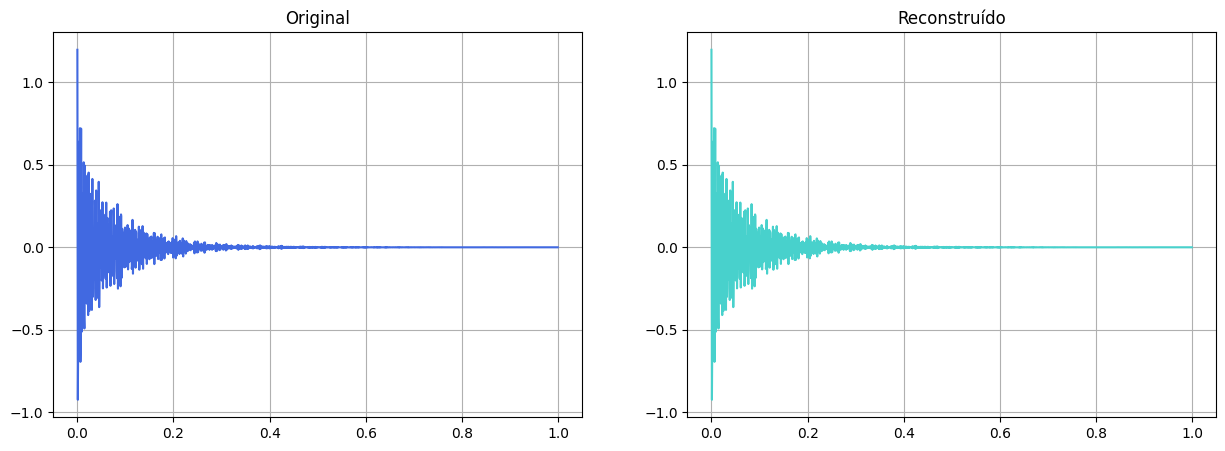

In [70]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(t, sig.real, c = "royalblue")
plt.title("Original")
plt.grid()

plt.subplot(122)
plt.plot(t, reconstructed_sig.real, c = "mediumturquoise")
plt.title("Reconstruído")
plt.grid()

In [ ]:
# a, b, c, d = z.real, z.imag, r.real, r.imag
# s0 = c/np.cos(np.arctan(d/c))
# phi = np.arctan(d/c)
# omega = (1/dt)*np.arctan(b/a)
# alpha = (1/dt)*np.log(np.cos(np.arctan(b/a))/a)

In [82]:
# z.real[z.real <= zero_filtering] = 0.0
# z.imag[z.imag <= zero_filtering] = 0.0
# r.real[r.real <= zero_filtering] = 0.0
# r.real[r.imag <= zero_filtering] = 0.0
# É melhor filtrar os valores zeros direto antes ?
s0, phi, omega, alpha = calculate_variables_from_z_and_r(z, r, dt)

In [83]:
with np.printoptions(threshold=np.inf):
    print("Generated \t\t\t\t|\t Original")
    print(omega, "\t\t|\t", ws)
    print(1/alpha, "\t\t\t|\t",  t2s)
    print(s0, "\t\t\t|\t",  M_0s)
    print(phi, "\t|\t",  spins_phi)
    # print(t2s)
    # print(ws)
    

Generated 				|	 Original
[3669.41457469 3416.52585124 3386.83088847 3239.1586412  2692.37004302
 2632.17755093 2355.21183064 2411.71251655 2500.55663488 2496.54380208] 		|	 [2355.21183064 2411.71251655 2496.54380208 2500.55663488 2632.17755093
 2692.37004302 3239.1586412  3386.83088847 3416.52585124 3669.41457469]
[0.1471 0.1053 0.1136 0.0926 0.1163 0.0833 0.0199 0.0735 0.0909 0.0066] 			|	 [0.0199 0.0735 0.0066 0.0909 0.0833 0.1163 0.0926 0.1136 0.1053 0.1471]
[0.0411 0.0202 0.0776 0.2026 0.0427 0.0451 0.2917 0.4289 0.0184 0.029 ] 			|	 [0.2917 0.4289 0.029  0.0184 0.0451 0.0427 0.2026 0.0776 0.0202 0.0411]
[ 2.85866579e-14  7.02133621e-13  7.58270880e-14 -6.69229945e-14
 -1.30855839e-13  5.98883471e-14  5.33886870e-13 -2.74093589e-13
 -6.63720286e-13 -2.63151569e-12] 	|	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
